In [27]:
# preamble, load all required packages and setup some stuff
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt
import pylab
import seaborn as sns
from mackey_glass import Mackey_Glass
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.ticker as mticker
s_fmt = mticker.ScalarFormatter(useMathText=True)

sns.set_theme(context='paper', style='whitegrid', palette='Dark2', font_scale=.75)  # for plots
pylab.rcParams['figure.dpi'] = 150

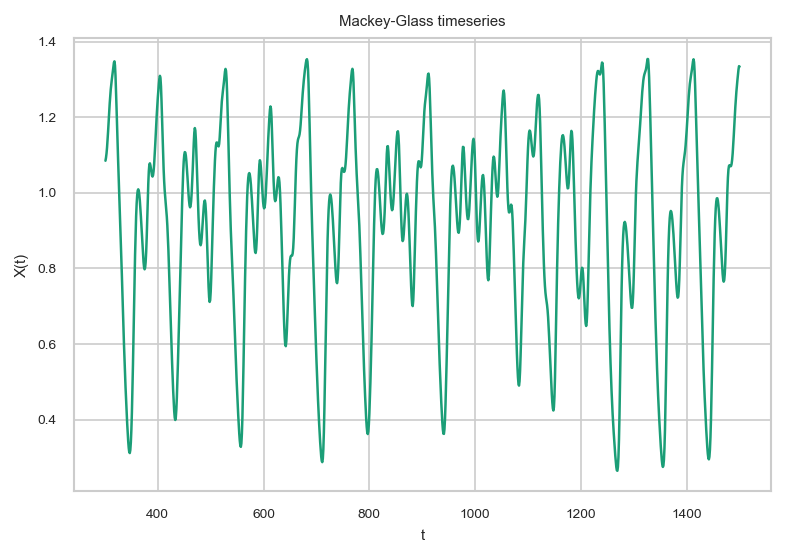

In [28]:
# plot Mackey-Glass timeseries
mg_df = pd.read_csv('data/mackey_glass.csv')

fig, ax = plt.subplots()
sns.lineplot(x='t', y='X(t+0)', data=mg_df, ax=ax)
ax.set_ylabel('X(t)')
ax.set_title('Mackey-Glass timeseries')
plt.show()

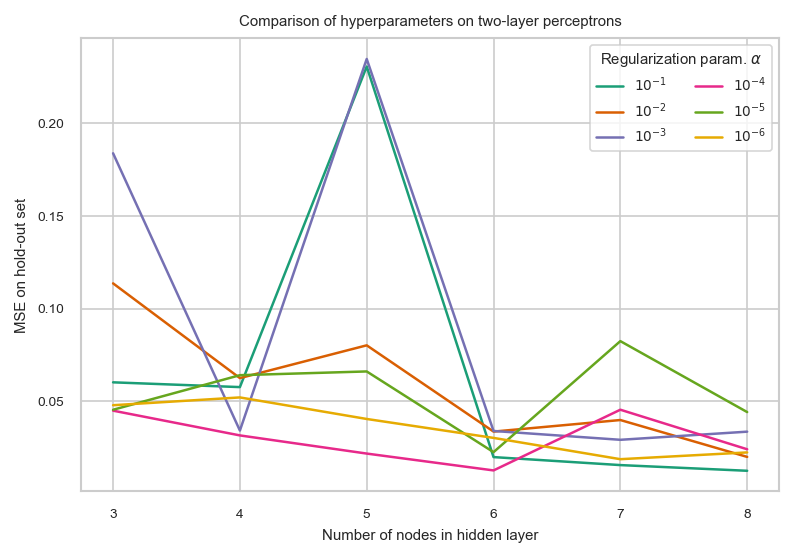

In [39]:
# load results of two-layer MLP eval and plot them
mlp_2_df = pd.read_csv('data/two_layer_perceptrons_scores.csv')
# mlp_2_df['alpha'] = mlp_2_df['alpha'].astype('category')
mlp_2_df['alpha_str'] = mlp_2_df['param_alpha'].apply(lambda x: f'${s_fmt.format_data(x)}$').astype('category')
mlp_2_df['layer0_nodes'] = mlp_2_df['param_hidden_layer_sizes'].apply(lambda t: eval(t)[0])
mlp_2_df['mse_avg'] = mlp_2_df['mean_test_score'].apply(lambda x: -1*x)
mlp_2_df['mse_std'] = mlp_2_df['std_test_score'].apply(lambda x: -1*x)

fig, ax = plt.subplots()
sns.lineplot(x='layer0_nodes', y='mse_avg', hue='alpha_str', data=mlp_2_df)
ax.set_xlabel('Number of nodes in hidden layer')
ax.set_ylabel('MSE on hold-out set')
ax.set_title('Comparison of hyperparameters on two-layer perceptrons')
ax.legend(title='Regularization param. $\\alpha$', ncol=2)
plt.show()

# # fig, ax = plt.subplots()
# # sns.lineplot(x='layer0_nodes', y='mse', hue='alpha', data=mlp_2_df, ax=ax)
# # ax.set_xlabel('Number of nodes in hidden layer')
# # ax.set_ylabel('MSE on hold-out set')
# # ax.set_title('Two-layer perceptron evaluation')
# # ax.legend(title='Regularization strength ($\\alpha$)', ncol=3)
# plt.show()

{'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': [8]}


c:\users\manue\workspace\annda_ht20_lab1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


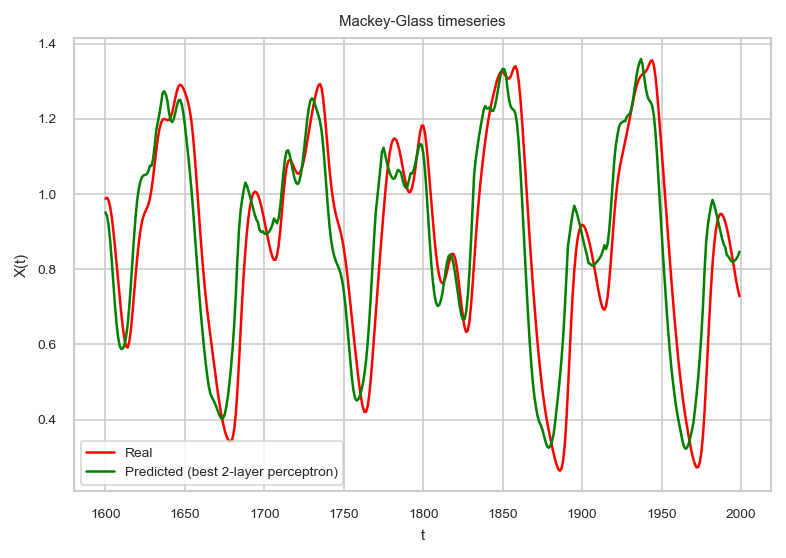

In [34]:
# build the best perceptron, train it and test it
# parameters have been stored as a json
with open('data/best_2l_mlp.json', 'r') as fp:
    best_2l_params = json.load(fp)
    
print(best_2l_params)

# turn Mackey-Glass DataFrame into numpy arrays
# scikit-learn uses input matrices with rows=samples, columns=features
# last column is the input t, we don't want that
X = mg_df.to_numpy()[:, :-2]
Y = mg_df.to_numpy()[:, -2]

# build test data
mg = Mackey_Glass()
test_t = list(range(1600, 2000))  # cleary unseen samples
Y_real = [mg.fn(t) for t in test_t]
X_test = np.array([[mg.fn(t + d) for d in [-20, -15, -10, -5, 0]] for t in test_t])

best_2layers = MLPRegressor(**best_2l_params)
best_2layers.fit(X, Y)

# now use the fitted estimator to predict
Y_pred = best_2layers.predict(X_test)

# plot predictions vs real values
fig, ax = plt.subplots()
ax.plot(test_t, Y_real, 'r-', label='Real')
ax.plot(test_t, Y_pred, 'g-', label='Predicted (best 2-layer perceptron)')
ax.set_xlabel('t')
ax.set_ylabel('X(t)')
ax.set_title('Mackey-Glass timeseries')
ax.legend()
plt.show()

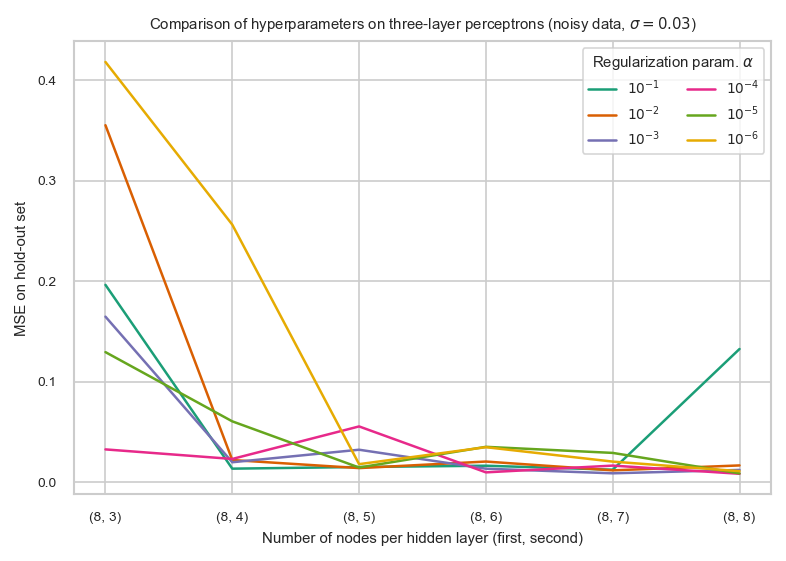

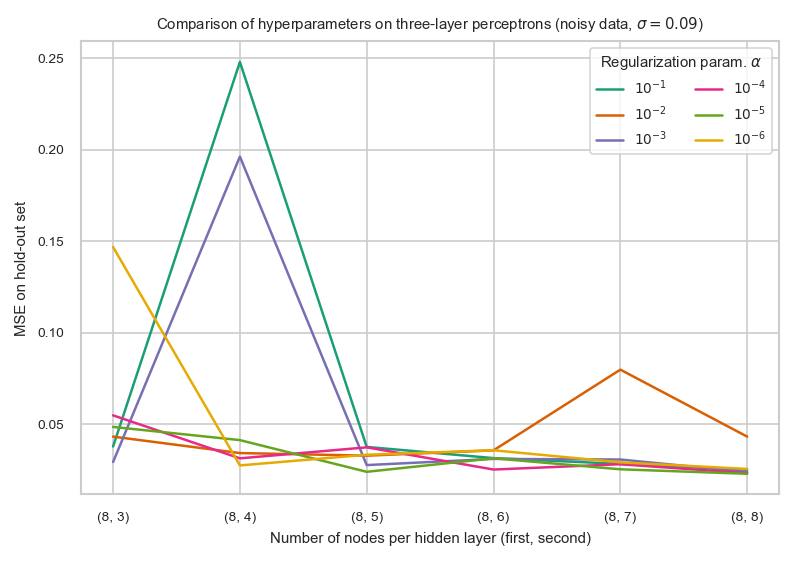

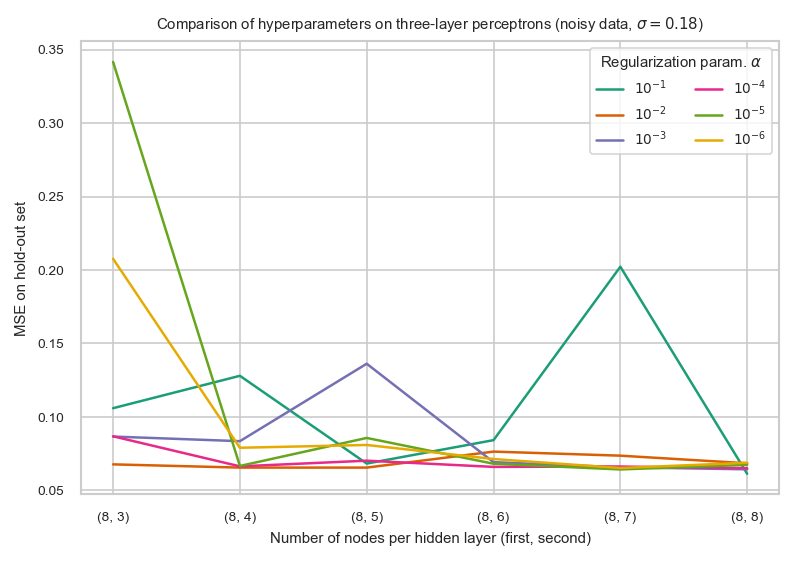

In [38]:
# load results of three-layer MLP eval and plot them
mlp_3_df = pd.read_csv('data/three_layer_perceptrons_scores.csv')

for noise_std, df in mlp_3_df.groupby('noise_std'):
    # one plot per noise level
    df = df.copy()
    
    df['alpha_str'] = df['param_alpha'].apply(lambda x: f'${s_fmt.format_data(x)}$').astype('category')
    df['layer1_nodes'] = df['param_hidden_layer_sizes'].apply(lambda t: eval(t)[1])
    df['mse_avg'] = df['mean_test_score'].apply(lambda x: -1*x)
    df['mse_std'] = df['std_test_score'].apply(lambda x: -1*x)
    
    fig, ax = plt.subplots()    
    sns.lineplot(x='param_hidden_layer_sizes', y='mse_avg', hue='alpha_str', data=df)
    ax.set_xlabel('Number of nodes per hidden layer (first, second)')
    ax.set_ylabel('MSE on hold-out set')
    ax.set_title(f'Comparison of hyperparameters on three-layer perceptrons (noisy data, $\sigma={noise_std}$)')
    ax.legend(title='Regularization param. $\\alpha$', ncol=2)
    plt.show()


# mlp_3_df['alpha'] = mlp_3_df['alpha'].astype('category')
# mlp_3_df['alpha_str'] = mlp_3_df['alpha'].apply(s_fmt.format_data).astype('category')

# # fig, ax = plt.subplots()
# fg = sns.relplot(kind='line', x='layer1_nodes', y='mse', hue='std', row='alpha_str', data=mlp_3_df)
# fg.set_xlabels('Number of nodes in second hidden layer')
# fg.set_ylabels('MSE on hold-out set')
# fg.set_titles('$\\alpha = {row_name}$')
# # fg.set_title('Three-layer perceptron evaluation')
# # fg.legend(title='Regularization strength ($\\alpha$)', ncol=3)

# plt.show()

c:\users\manue\workspace\annda_ht20_lab1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


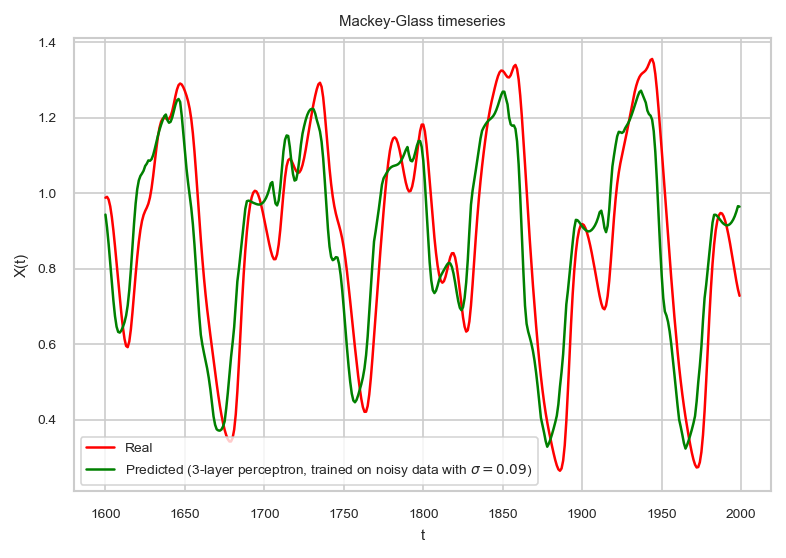

In [43]:
# load the best 3-layer perceptron for the 0.09 data
with open('data/best_3l_mlp_std0.09.json', 'r') as fp:
    best_3l_009_params = json.load(fp)

# build the best perceptron, train it and test it
best_3layers_009 = MLPRegressor(**best_3l_009_params)
best_3layers_009.fit(X, Y)

# now use the fitted estimator to predict
Y_pred = best_3layers_009.predict(X_test)

# plot predictions vs real values
fig, ax = plt.subplots()
ax.plot(test_t, Y_real, 'r-', label='Real')
ax.plot(test_t, Y_pred, 'g-', label='Predicted (3-layer perceptron, trained on noisy data with $\sigma=0.09$)')
ax.set_xlabel('t')
ax.set_ylabel('X(t)')
ax.set_title('Mackey-Glass timeseries')
ax.legend()
plt.show()

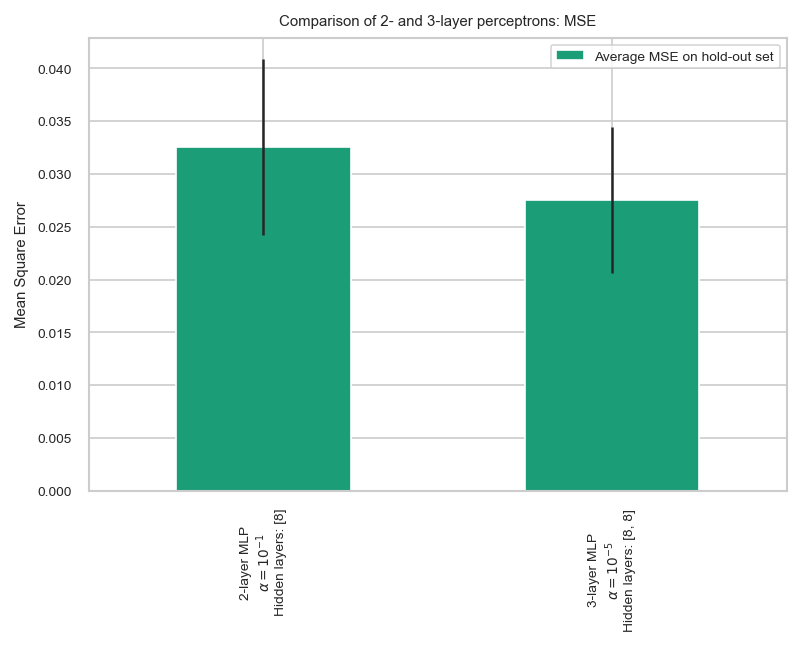

In [73]:
# compare the best 2-layer MLP and 3-layer MLP on noisy data (std = 0.09)

mlp_2v3_df = pd.read_csv('data/2v3_noisy.0.09.csv')
mlp_2v3_df['mse_avg'] = mlp_2v3_df['mean_test_score'].apply(lambda x: -1*x)
mlp_2v3_df['mse_std'] = mlp_2v3_df['std_test_score'].apply(lambda x: -1*x)
# mlp_2v3_df['n_layers'] = mlp_2v3_df['n_layers'].astype('category')

# params_2l = best_2layers.get_params()
# params_3l = best_3layers.get_params()

fig, ax = plt.subplots()
mlp_2v3_df.plot(kind='bar', x='param_hidden_layer_sizes', y='mse_avg', yerr='mse_std', ax=ax, label='Average MSE on hold-out set')
ax.set_xlabel('')
ax.set_xticklabels(
    [
        f'2-layer MLP\n$\\alpha={s_fmt.format_data(best_2l_params["alpha"])}$\nHidden layers: {best_2l_params["hidden_layer_sizes"]}',
        f'3-layer MLP\n$\\alpha={s_fmt.format_data(best_3l_009_params["alpha"])}$\nHidden layers: {best_3l_009_params["hidden_layer_sizes"]}',
    ]
)
ax.set_ylabel('Mean Square Error')
ax.set_title('Comparison of 2- and 3-layer perceptrons: MSE')
plt.show()

# sns.violinplot(data=mlp_2v3_df, x='n_layers', y='mse', ax=ax)
# ax.set_xlabel('MLP')
# ax.set_xticklabels([f'2-layer MLP\n$\\alpha={s_fmt.format_data(params_2l["alpha"])}$\nHidden layers: {params_2l["hidden_layer_sizes"]}', 
#                     f'3-layer MLP\n$\\alpha={s_fmt.format_data(params_3l["alpha"])}$\nHidden layers: {params_3l["hidden_layer_sizes"]}'])
# ax.set_ylabel('Mean Square Error on hold-out set')
# ax.set_title('Comparison of best 2- and 3-layer perceptrons on noisy data')
# plt.show()

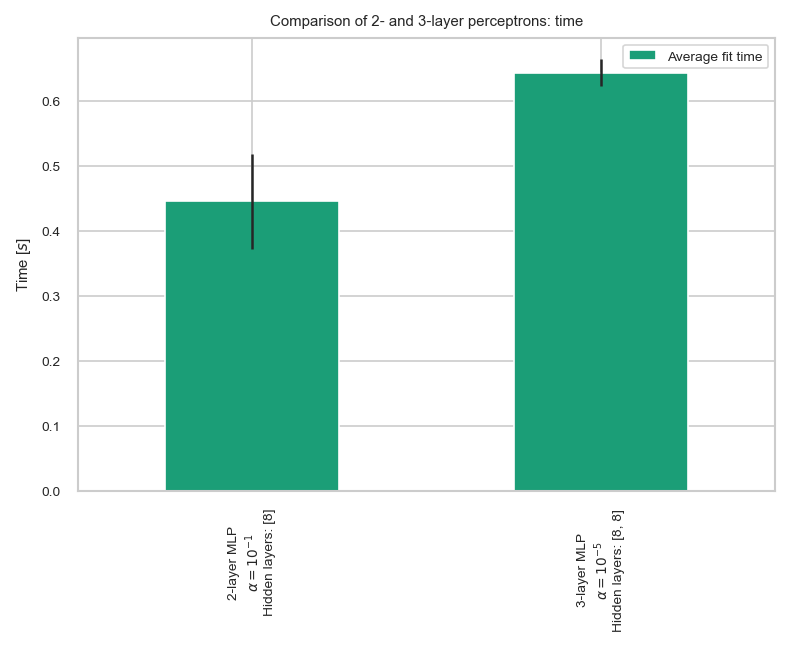

In [72]:
# some time plots
fig, ax = plt.subplots()
mlp_2v3_df.plot(kind='bar', x='param_hidden_layer_sizes', y='mean_fit_time', yerr='std_fit_time', ax=ax, label='Average fit time')
ax.set_xlabel('')
ax.set_xticklabels(
    [
        f'2-layer MLP\n$\\alpha={s_fmt.format_data(best_2l_params["alpha"])}$\nHidden layers: {best_2l_params["hidden_layer_sizes"]}',
        f'3-layer MLP\n$\\alpha={s_fmt.format_data(best_3l_009_params["alpha"])}$\nHidden layers: {best_3l_009_params["hidden_layer_sizes"]}',
    ]
)
ax.set_ylabel('Time [$s$]')
ax.set_title('Comparison of 2- and 3-layer perceptrons: time')
plt.show()

# sns.violinplot(x='n_layers', y='training_time', data=mlp_2v3_df, ax=ax)
# ax.set_xlabel('MLP')
# ax.set_xticklabels([f'2-layer MLP\n$\\alpha={s_fmt.format_data(params_2l["alpha"])}$\nHidden layers: {params_2l["hidden_layer_sizes"]}', 
#                     f'3-layer MLP\n$\\alpha={s_fmt.format_data(params_3l["alpha"])}$\nHidden layers: {params_3l["hidden_layer_sizes"]}'])
# ax.set_ylabel('Training time [$s$]')
# ax.set_title('Comparison of best 2- and 3-layer perceptrons training time')
# plt.show()

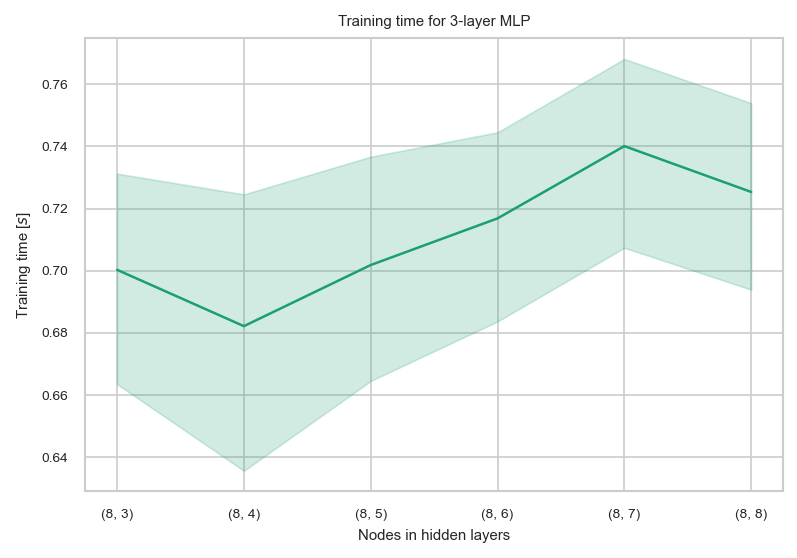

In [85]:
# time cost of fitting 3-layer MLP

fig, ax = plt.subplots()
sns.lineplot( x='param_hidden_layer_sizes', y='mean_fit_time', ax=ax, data=mlp_3_df)

# for std, df in mlp_3_df.groupby('noise_std'):
#     df.plot(kind='line', x='param_hidden_layer_sizes', y='mean_fit_time', yerr='std_fit_time', ax=ax, label=f'${std}$')
    
# sns.lineplot(x='param_hidden_layer_sizes', y='mean_fit_time', data=mlp_3_df, ax=ax)
ax.set_xlabel('Nodes in hidden layers')
ax.set_ylabel('Training time [$s$]')
ax.set_title(f'Training time for 3-layer MLP')
plt.show()